In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [25]:
from keras.datasets import mnist

Plan for creating Neural Network from scratch

![Alt text](image-1.png)

In [3]:
from keras.datasets import mnist

#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

#printing the shapes of the vectors 
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


To calculate the error margin, we will use back prop to do that.

![Alt text](image.png)

In [26]:
# Example loading data, replace this with your actual data loading code
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Reshape the images from (number_of_images, 28, 28) to (number_of_images, 784)
train_X_flattened = train_X.reshape(train_X.shape[0], -1)
test_X_flattened = test_X.reshape(test_X.shape[0], -1)

# Normalize the pixel values to the range [0, 1]
train_X_flattened = train_X_flattened / 255.0
test_X_flattened = test_X_flattened / 255.0

# Transpose the data if each column should represent an image
train_X_flattened = train_X_flattened.T
test_X_flattened = test_X_flattened.T


In [17]:
def init_params():
    """
    Initialize the parameters of a 2-layer neural network.
    The network has 784 input features and 10 output units in each layer.
    
    Returns:
    W1, b1: Weight and bias for the first layer.
    W2, b2: Weight and bias for the second layer.
    """
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    #b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    b1 = np.zeros((10, 1))
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    #b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    b2 = np.zeros((10, 1))

    return W1, b1, W2, b2

def ReLU(Z):
    """
    Apply the Rectified Linear Unit (ReLU) function element-wise.
    
    Z: Input array.
    
    Returns:
    Array with ReLU applied (all negative elements set to 0).
    """
    return np.maximum(0, Z)


def LeakyReLU(Z, alpha=0.01):
    return np.where(Z > 0, Z, alpha * Z)

def softmax(Z):
    """
    Apply the softmax function to each column of the input array.
    
    Z: Input array.
    
    Returns:
    Softmax applied array.
    """
    Z -= np.max(Z, axis=0)  # Improve numerical stability
    exp_Z = np.exp(Z)
    return exp_Z / (np.sum(exp_Z, axis=0, keepdims=True) + 1e-8)

def forward_prop(W1, b1, W2, b2, X):
    """
    Perform forward propagation through the network.
    
    W1, b1: Weight and bias for the first layer.
    W2, b2: Weight and bias for the second layer.
    X: Input data (each column is an input example).
    
    Returns:
    Z1, A1: Pre-activation and post-activation values for the first layer.
    Z2, A2: Pre-activation and post-activation values for the second layer.
    """
    Z1 = W1.dot(X) + b1       # Linear step for layer 1
    A1 = LeakyReLU(Z1)             # Activation step for layer 1
    Z2 = W2.dot(A1) + b2      # Linear step for layer 2
    A2 = softmax(Z2)          # Activation step for layer 2 (softmax)
    return Z1, A1, Z2, A2

def one_hot(Y):
    """
    Convert a vector of labels to one-hot encoding.
    
    Y: Input array of labels.
    
    Returns:
    One-hot encoded matrix.
    """
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def deriv_ReLU(Z):
    """
    Compute the derivative of the ReLU function.
    
    Z: Input array.
    
    Returns:
    Array with derivatives of ReLU.
    """
    return Z > 0


def deriv_LeakyReLU(Z, alpha=0.01):
    return np.where(Z > 0, 1, alpha)

def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    """
    Perform backpropagation to compute gradients.
    
    Z1, A1: Pre-activation and post-activation values for the first layer.
    Z2, A2: Pre-activation and post-activation values for the second layer.
    W2: Weight matrix for the second layer.
    X: Input data.
    Y: True labels.
    
    Returns:
    dW1, db1: Gradients of loss with respect to W1 and b1.
    dW2, db2: Gradients of loss with respect to W2 and b2.
    """
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y        # Derivative of loss with respect to Z2
    dW2 = 1 / m * dZ2.dot(A1.T) # Gradient of loss with respect to W2
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True) # Gradient of loss with respect to b2; corrected axis
    dZ1 = W2.T.dot(dZ2) * deriv_LeakyReLU(Z1) # Derivative of loss with respect to Z1
    dW1 = 1 / m * dZ1.dot(X.T)  # Gradient of loss with respect to W1
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True) # Gradient of loss with respect to b1; corrected axis

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    """
    Update the parameters of the network using gradient descent.
    
    W1, b1: Current weight and bias for the first layer.
    W2, b2: Current weight and bias for the second layer.
    dW1, db1: Gradients for W1 and b1.
    dW2, db2: Gradients for W2 and b2.
    alpha: Learning rate.
    
    Returns:
    Updated W1, b1, W2, b2.
    """
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * np.reshape(db1, (10, 1))
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * np.reshape(db2, (10, 1))

    return W1, b1, W2, b2


In [18]:
def get_predictions(A2):
    """
    Generate predictions from the output layer's activations.

    A2: The output activations from the last layer of the neural network, 
        where each column corresponds to the activations for a given input example.

    Returns:
    An array of predicted class labels for each input example.
    """
    return np.argmax(A2, 0)  # np.argmax returns the indices of the max values along axis 0.

def get_accuracy(predictions, Y):
    """
    Calculate the accuracy of predictions against the true labels.

    predictions: An array of predicted class labels.
    Y: The true labels.

    Returns:
    The accuracy as a float.
    """
    print(predictions, Y)  # Optionally print the predictions and true labels for inspection.
    return np.sum(predictions == Y) / Y.size  # Calculate the proportion of correct predictions.

def compute_loss(A2, Y):
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(A2)) / m
    return loss

def gradient_descent(X, Y, iterations, alpha, W1=None, b1=None, W2=None, b2=None):
    """
    Perform gradient descent to train the neural network.

    X: Input data, where each column is an input example (e.g., a flattened image).
    Y: True labels for the input data.
    iterations: The number of iterations to train the network.
    alpha: The learning rate.

    Returns:
    The final weights and biases after training.
    """
    if W1 is None or b1 is None or W2 is None or b2 is None:
        W1, b1, W2, b2 = init_params()  # Initialize parameters.
        
    for i in range(iterations):
        # Forward propagation.
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)

        # Backward propagation.
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)

        # Update parameters.
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        # Print accuracy every 50 iterations.
        if i % 50 == 0:
            loss = compute_loss(A2, one_hot(Y))
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print("Iteration: ", i, "Loss: ", loss, "Accuracy: ", get_accuracy(predictions, Y))
    return W1, b1, W2, b2


In [7]:
alpha = 0.05
iterations = 2500

Train Model

In [8]:
W1, b1, W2, b2 = gradient_descent(train_X_flattened, train_y, iterations, alpha)

Iteration:  0
[2 0 9 ... 9 0 2] [5 0 4 ... 5 6 8]
Iteration:  0 Loss:  2.2881517273087946 Accuracy:  0.1333
Iteration:  50
[3 0 3 ... 9 0 8] [5 0 4 ... 5 6 8]
Iteration:  50 Loss:  1.7508805623358452 Accuracy:  0.5039
Iteration:  100
[3 0 4 ... 9 0 8] [5 0 4 ... 5 6 8]
Iteration:  100 Loss:  1.2329154876591089 Accuracy:  0.7041166666666666
Iteration:  150
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  150 Loss:  0.8583140430423932 Accuracy:  0.8090333333333334
Iteration:  200
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  200 Loss:  0.6665745349034801 Accuracy:  0.8394666666666667
Iteration:  250
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  250 Loss:  0.5701338941059922 Accuracy:  0.8559666666666667
Iteration:  300
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  300 Loss:  0.5124126652323541 Accuracy:  0.8657
Iteration:  350
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  350 Loss:  0.4734855105529864 Accuracy:  0.8740166666666667
Iteration:  400
[3 0 4 ... 5 6 8] [5 0 4 ... 5 6 8

In [15]:
import pickle

Save Model

In [14]:
import os
import re

In [13]:
def get_latest_model_version(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        return 0  # No models saved yet

    model_files = [f for f in os.listdir(directory) if re.match(r'model_v\d+\.pkl', f)]
    if not model_files:
        return 0  # No versioned model files found

    # Extract version numbers and find the maximum
    versions = [int(re.search(r'(\d+)', f).group()) for f in model_files]
    return max(versions)

In [19]:
def save_model(W1, b1, W2, b2, directory='models'):
    latest_version = get_latest_model_version(directory)
    next_version = latest_version + 1
    filename = f'model_v{next_version}.pkl'
    filepath = os.path.join(directory, filename)

    model_params = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }

    with open(filepath, 'wb') as file:
        pickle.dump(model_params, file)
    print(f"Model saved as {filename} in {directory}")


In [37]:
save_model(W1, b1, W2, b2)

Model saved as model_v6.pkl in models


Load Model

In [11]:
def load_model(directory='models'):
    latest_version = get_latest_model_version(directory)
    if latest_version == 0:
        raise FileNotFoundError("No saved model found in the directory.")

    filename = f'model_v{latest_version}.pkl'
    filepath = os.path.join(directory, filename)

    with open(filepath, 'rb') as file:
        model_params = pickle.load(file)
        print(f"Loaded model version {latest_version} from {filepath}")
        return model_params['W1'], model_params['b1'], model_params['W2'], model_params['b2']


In [27]:
# Load the model
W1, b1, W2, b2 = load_model()

Loaded model version 4 from models\model_v4.pkl


Conitnue Training Model

In [35]:
alpha = 0.001
iterations = 50000

In [36]:
W1, b1, W2, b2 = gradient_descent(train_X_flattened, train_y, iterations, alpha, W1, b1, W2, b2)

Iteration:  0
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  0 Loss:  0.19205889744916207 Accuracy:  0.9459666666666666
Iteration:  50
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  50 Loss:  0.192057709258842 Accuracy:  0.9459666666666666
Iteration:  100
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  100 Loss:  0.19205652159724862 Accuracy:  0.9459666666666666
Iteration:  150
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  150 Loss:  0.19205533427887203 Accuracy:  0.9459666666666666
Iteration:  200
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  200 Loss:  0.19205414656749592 Accuracy:  0.9459666666666666
Iteration:  250
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  250 Loss:  0.19205295879034 Accuracy:  0.9459666666666666
Iteration:  300
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  300 Loss:  0.19205177148247835 Accuracy:  0.9459833333333333
Iteration:  350
[5 0 4 ... 5 6 8] [5 0 4 ... 5 6 8]
Iteration:  350 Loss:  0.19205058459786895 Accuracy:  0.9459833333333333
Iteration: 

In [9]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)

    return predictions

def test_prediction(index, W1, b1, W2, b2):
    # Extracting the image and reshaping it to column vector
    current_image = train_X[index].reshape(784, 1) / 255.0
    prediction = make_predictions(current_image, W1, b1, W2, b2)
    label = train_y[index]
    
    print("Prediction: ", prediction[0])  # [0] to get the scalar value
    print("Label: ", label)

    # Reshaping the image for visualization
    current_image = current_image.reshape((28, 28))
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  5
Label:  5


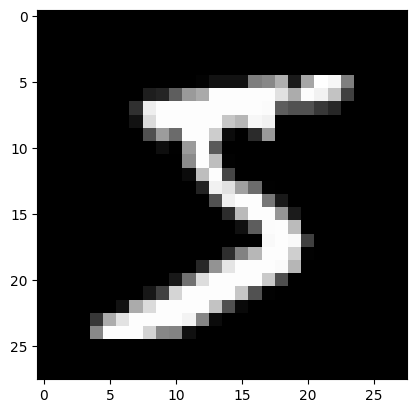

In [46]:
test_prediction(0, W1, b1, W2, b2)

In [1]:
import cv2
import os

In [2]:
from skimage import util 

In [3]:
def save_processed_image(image, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    file_name = os.path.join(path, name + ".png")
    cv2.imwrite(file_name, image)
    print(f"Saved processed image to {file_name}")

In [23]:
def preprocess_frame(ROI, save_image=False, image_path='', image_name='image'):
    # Convert to grayscale
    gray_image = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding
    _, thresholded_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    # Resize the image to 28x28
    resized_image = cv2.resize(thresholded_image, (28, 28))

    # Invert the grayscale image
    inverted_image = cv2.bitwise_not(resized_image)

    # Flatten the resized (and potentially inverted) image
    flattened_image = inverted_image.flatten().reshape((784, 1))

    # Save the processed image
    if save_image:
        cv2.imwrite(f'{image_path}/{image_name}.png', inverted_image)

    return flattened_image

In [5]:

def preprocess_frame(frame):
    """
    Preprocess the frame to match MNIST dataset format.

    frame: Captured image from the camera.
    
    Returns:
    Processed image ready for prediction.
    """
    # Convert to grayscale
    if len(frame.shape) == 3 and frame.shape[2] == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Resize to 28x28 (MNIST format)
    frame_resized = cv2.resize(frame, (28, 28), interpolation=cv2.INTER_AREA)

    # Invert colors if necessary (digit should be white on black background)
    frame_inverted = cv2.bitwise_not(frame_resized)

    # Normalize pixel values to be between 0 and 1
    frame_normalized = frame_inverted / 255.0

    # Flatten the image to a 784-element array
    frame_flattened = frame_normalized.flatten().reshape(784, 1)

    return frame_flattened



In [6]:
import cv2
import matplotlib.pyplot as plt

In [7]:
def capture_and_predict(W1, b1, W2, b2):
    cap = cv2.VideoCapture(0)
    ROI_size = 200
    save_next_frame = False
    frame_count = 0

    while True:
        ret, frame, ROI = capture_frame(cap, ROI_size)
        if not ret:
            capture_and_predict(W1, b1, W2, b2)

        # Check for space bar press to save the next frame
        key = cv2.waitKey(10)
        if key == 32:  # Space bar key code
            save_next_frame = True

        processed_ROI = preprocess_frame(ROI, save_image=save_next_frame, 
                                         image_path='images/processed_images/', 
                                         image_name='processed_img_{}'.format(frame_count))

        # Reset save_next_frame after saving
        if save_next_frame:
            save_next_frame = False
            frame_count += 1

        predicted_digit = make_predictions(processed_ROI, W1, b1, W2, b2)[0]
        display_prediction(frame, predicted_digit, ROI_size)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

def capture_frame(cap, ROI_size):
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        return False, frame, None

    x_start, y_start = calculate_ROI_start(cap, ROI_size)
    ROI = frame[y_start:y_start + ROI_size, x_start:x_start + ROI_size]
    draw_ROI(frame, x_start, y_start, ROI_size)
    return True, frame, ROI

def calculate_ROI_start(cap, ROI_size):
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    x_start = (frame_width - ROI_size) // 2
    y_start = (frame_height - ROI_size) // 2
    return x_start, y_start

def draw_ROI(frame, x_start, y_start, ROI_size):
    cv2.rectangle(frame, (x_start, y_start), (x_start + ROI_size, y_start + ROI_size), (0, 255, 0), 3)

def display_prediction(frame, predicted_digit, ROI_size):
    cv2.putText(frame, f'Pred: {predicted_digit}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Digit Recognition', frame)


In [34]:
# Make sure to initialize your model parameters (W1, b1, W2, b2) before calling this function
capture_and_predict(W1, b1, W2, b2)